# <center><p style ="color: royalblue; font-weight: 500">Titanic competition</p></center>

<center>>>> Nguyễn Ngọc Trí Vĩ <<<

Link competitions: https://www.kaggle.com/competitions/titanic

### Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score


### Import and preprocess data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

#### Preprocessing train dataset

In [3]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Check how many null value in this train dataset

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Split the ticket to ticket number and ticket prefix
- Fill NaN value
- Rescale ticket number
- Convert sex to binary (0 is female, 1 is male)
- Label the ticket prefix
- Label the first letter of cabin

In [5]:
train_df = train_df.replace({'Ticket': {'LINE': ' 0'}})

ticketprefix = train_df['Ticket'].str.split(' ').str[0].apply(lambda x: x if x.isnumeric() == False else 'None')

train_df = train_df.assign(TicketPrefix = ticketprefix)
train_df['TicketPrefix'] = train_df['TicketPrefix'].str.replace('/', ' ').str.replace('.', '')
train_df['TicketPrefix'] = pd.Categorical(train_df['TicketPrefix'])
train_df['TicketPrefix'] = train_df['TicketPrefix'].cat.codes


sex = pd.get_dummies(train_df['Sex'], dtype= np.int32)
sex = sex.rename(columns={'male': "Male"})

train_df = pd.concat((train_df, sex),axis=1)

train_df = train_df.drop(train_df.loc[train_df["Age"] > 75].index)
train_df = train_df.drop(train_df.loc[train_df["SibSp"] > 7].index)
train_df = train_df.drop(train_df.loc[train_df["Fare"] > 510].index)

age_male = train_df["Age"][train_df.loc[train_df["Male"] != 0].index].mean()
age_female = train_df["Age"][train_df.loc[train_df["Male"] == 0].index].mean()

train_df.loc[train_df.Male != 0, 'Age'] = train_df.loc[train_df.Male != 0, 'Age'].fillna(age_male)
train_df.loc[train_df.Male == 0, 'Age'] = train_df.loc[train_df.Male == 0, 'Age'].fillna(age_female)

train_df["Cabin"].fillna("Other", inplace = True)
train_df["Embarked"].fillna(method = 'ffill', inplace = True)
train_df['Cabin'] = train_df['Cabin'][:].str[0]
train_df['Ticket'] = train_df['Ticket'].str.split(' ').str[-1].astype(int)


X = train_df[['Ticket']]
scale = StandardScaler()
scale.fit(X)
train_df[['Ticket']] = scale.transform(X)

train_target = train_df['Survived']

train_df = train_df.drop(columns=['Name', 'PassengerId', 'Survived', 'female', 'Sex'])
train_df = train_df.replace({'Embarked': {'S': 0, 'C': 1, 'Q': 2}})
train_df = train_df.replace({'Cabin': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'T': 9, 'O': 0}})

train_df

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,Male
0,3,22.000000,1,0,-0.423775,7.2500,0,0,2,1
1,1,38.000000,1,0,-0.429193,71.2833,3,1,14,0
2,3,26.000000,0,0,4.247588,7.9250,0,0,30,0
3,1,35.000000,1,0,-0.283288,53.1000,3,0,12,0
4,3,35.000000,0,0,0.110499,8.0500,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,-0.135064,13.0000,0,0,12,1
887,1,19.000000,0,0,-0.285942,30.0000,2,0,12,0
888,3,27.888462,1,2,-0.445863,23.4500,0,0,32,0
889,1,26.000000,0,0,-0.286979,30.0000,3,1,12,1


#### Preprocessing test dataset

In [6]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The same with train dataset

In [8]:
test_df["Cabin"].fillna("Other", inplace = True)
test_df["Fare"].fillna(train_df['Fare'].mean(), inplace = True)

ticketprefix = test_df['Ticket'].str.split(' ').str[0].apply(lambda x: x if x.isnumeric() == False else 'None')

test_df = test_df.assign(TicketPrefix = ticketprefix)
test_df['TicketPrefix'] = test_df['TicketPrefix'].str.replace('/', ' ').str.replace('.', '')
test_df['TicketPrefix'] = pd.Categorical(test_df['TicketPrefix'])
test_df['TicketPrefix'] = test_df['TicketPrefix'].cat.codes


sex = pd.get_dummies(test_df['Sex'], dtype= np.int32)
sex = sex.rename(columns={'male': "Male"})

test_df = pd.concat((test_df, sex),axis=1)

test_df['Cabin'] = test_df['Cabin'][:].str[0]

test_df.loc[test_df.Male != 0, 'Age'] = test_df.loc[test_df.Male != 0, 'Age'].fillna(age_male)
test_df.loc[test_df.Male == 0, 'Age'] = test_df.loc[test_df.Male == 0, 'Age'].fillna(age_female)

test_df['Ticket'] = test_df['Ticket'].str.split(' ').str[-1].astype(int)

X = test_df[['Ticket']]
test_df[['Ticket']] = scale.transform(X)

PassengerID = test_df['PassengerId']

test_df = test_df.drop(columns=['Name', 'PassengerId', 'female', 'Sex'])
test_df = test_df.replace({'Embarked': {'S': 0, 'C': 1, 'Q': 2}})
test_df = test_df.replace({'Cabin': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'T': 9, 'O': 0}})
test_df

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,Male
0,3,34.500000,0,0,0.045983,7.8292,0,2,11,1
1,3,47.000000,1,0,0.095062,7.0000,0,0,11,0
2,2,62.000000,0,0,-0.091476,9.6875,0,2,11,1
3,3,27.000000,0,0,0.022086,8.6625,0,0,11,1
4,3,22.000000,1,1,4.247613,12.2875,0,0,11,0
...,...,...,...,...,...,...,...,...,...,...
413,3,30.595933,0,0,-0.450976,8.0500,0,0,3,1
414,1,39.000000,0,0,-0.428952,108.9000,3,1,12,0
415,3,38.500000,0,0,4.247558,7.2500,0,0,23,1
416,3,30.595933,0,0,0.089052,8.0500,0,0,11,1


### Predict

##### Finetune XGBoost with GridSearchCV

In [9]:
# grid search
model = XGBClassifier()
n_estimators = [90, 100, 110, 120, 130]
max_depth = [3, 4, 5, 6]
learning_rate = [0.11, 0.12, 0.13, 0.14, 0.09]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate = learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(train_df,train_target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best: 0.790764 using {'learning_rate': 0.11, 'max_depth': 5, 'n_estimators': 120}
0.773659 (0.046560) with: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 90}
0.777516 (0.038919) with: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 100}
0.779051 (0.043812) with: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 110}
0.780193 (0.040747) with: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 120}
0.780949 (0.047115) with: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 130}
0.783621 (0.041786) with: {'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 90}
0.782371 (0.044375) with: {'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 100}
0.775107 (0.036569) with: {'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 110}
0.772249 (0.042537) with: {'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 120}
0.777212 (0.050256) with: {'learning_rate': 0.11, 'max_depth': 4, 'n_est

##### Train and predict with XGBoost

accuracy: 0.9670454545454545  F1-Score: 0.9562594268476622


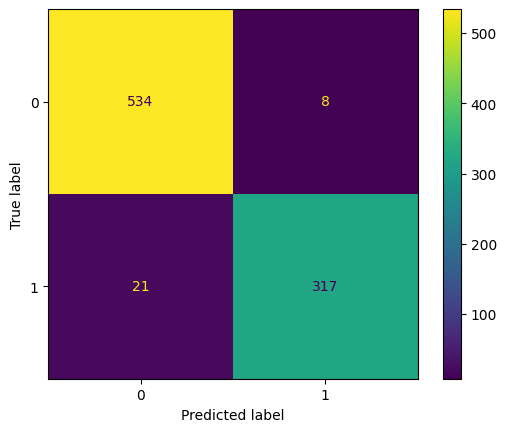

In [10]:
model = XGBClassifier(n_estimators = 100, max_depth = 7, learning_rate = 0.119)

model.fit(train_df,train_target)
 
predict_train = model.predict(train_df)

accuracy_train = accuracy_score(train_target,predict_train)
print('accuracy:', accuracy_train, ' F1-Score:', f1_score(train_target,predict_train))

cm = confusion_matrix(train_target, model.predict(train_df))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot() 

predict_test = model.predict(test_df)

output = pd.DataFrame({'PassengerId': PassengerID, 'Survived': predict_test})
output.to_csv('submission.csv', index=False)

##### Train and predict with RandomForest with static random state and hyperparameters

accuracy: 0.9079545454545455  F1-Score: 0.8695652173913043


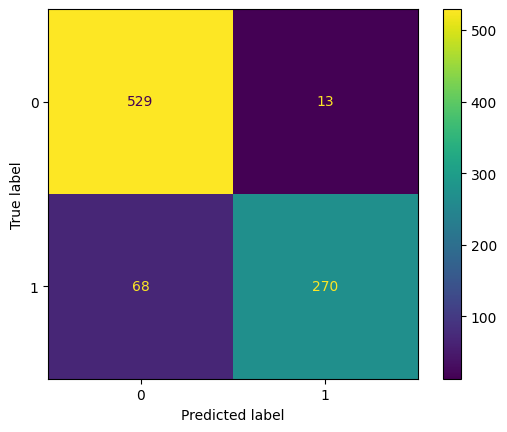

In [11]:
model = RandomForestClassifier(n_estimators = 210, max_depth=7, random_state=13, min_samples_split=4)

model.fit(train_df,train_target)
 
predict_train = model.predict(train_df)

accuracy_train = accuracy_score(train_target,predict_train)
print('accuracy:', accuracy_train, ' F1-Score:', f1_score(train_target,predict_train))

cm = confusion_matrix(train_target, model.predict(train_df))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot() 

predict_test = model.predict(test_df)

output = pd.DataFrame({'PassengerId': PassengerID, 'Survived': predict_test})
output.to_csv('submission.csv', index=False)

In [12]:
# grid search
model = RandomForestClassifier()
n_estimators = [70, 80, 90, 100, 110]
max_depth = [4, 5, 6, 7]
min_samples_split = [2, 4]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split = min_samples_split)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=5, verbose=1)
grid_result = grid_search.fit(train_df,train_target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best: 0.774627 using {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
0.718665 (0.057668) with: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 70}
0.729299 (0.069511) with: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 80}
0.721785 (0.061524) with: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 90}
0.723341 (0.062996) with: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.731212 (0.052638) with: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 110}
0.741880 (0.030695) with: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 70}
0.739823 (0.042295) with: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 80}
0.731182 (0.037120) with: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 90}
0.724596 (0.048024) with: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 100}
0.723800 (0.056218) with: {'max_depth': 4, 'min_samples_split': 4, 'n

accuracy: 0.9102272727272728  F1-Score: 0.8736


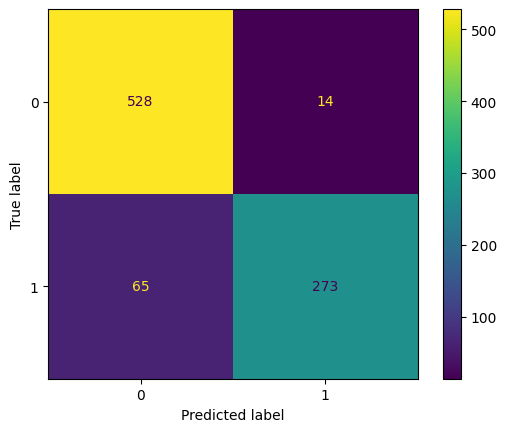

In [13]:
model = RandomForestClassifier(max_depth=7, n_estimators=100, min_samples_split=2)

model.fit(train_df,train_target)

predict_train = model.predict(train_df)

accuracy_train = accuracy_score(train_target,predict_train)
print('accuracy:', accuracy_train, ' F1-Score:', f1_score(train_target,predict_train))

cm = confusion_matrix(train_target, model.predict(train_df))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot() 

predict_test = model.predict(test_df)

output = pd.DataFrame({'PassengerId': PassengerID, 'Survived': predict_test})
output.to_csv('submission.csv', index=False)